# initialPlanningAndTests.ipynb
## Marcus Viscardi,    February 13, 2024


## From JA:
* (i) figure or subpanel containing poly(A) tail information, and reproducibility of measurements at various read count cutoffs
* (ii) supp figure or subpanel reproducibility of abundance (avg count, or SD/avg) at various read count cutoffs, to justify the counts we chose
* (iii) supp figure or subpanel  with “saturation analysis”, showing how many genes we contain reads for.

## Planning:
### Target (i): Tail information and reproducibility
I have done this analysis at some point. I think it predated the poly(A) paper?! I will need to find the code where I decided on the cutoffs for reads.
3 plots:
1. Standards: violin with 10, 15, and 60 bp tails
    - I produced these recently for Josh, just polish them and pop them in!
2. Subsampled tails: x-axis = number_of_test_samples, y-axis = mean_tail_length (and SEM)
    - This will be a plot for each standard.
3. Reproducibility of tail uniqueness (for CDFs we use):
    - CDF for subsets of reads per standard (eg. 5, 10, 25, 50)
    - Perform each subsetting 100 times or so, this will give us a bunch of CDFs
    - Then take the middle 95% of the CDFs and the mean of the middle 95% of the CDFs for each tail length
    - Plot the mean CDF and the 95% +/- CDFs for each tail standard (10, 15, & 60)
    - This will give us a good way to show that we can differentiate between tails and that we can do so reproducibly!
### Target (ii): Reproducibility of abundance
X-axis = RPM/read counts for per gene
Y-axis = SD/avg RPM/read counts per gene

This could be an overall scatter, or instead take the average of the SD/avg for each read_count bin and plot that as a line. This should show that at some point the data doesn't keep getting "better" with more depth

Another way to target the same idea is just a rocket plot with a vertical and horizontal cutoff showing what we identified as out cutoff!


### Target (iii): Saturation analysis
I did this for the Poly(A) paper in [subsamplingReadsVsProteinCoding.ipynb](../polyA_manuscriptPostReviewScripts/subsamplingReadsVsProteinCoding.ipynb). I just adjusted some inputs and ran it again... Worked great!

Josh thinks we could additionally have a plot with:
X-axis = reads_per_gene cutoff (1 to 200?)
Y-axis = cumulative number of genes above X cutoff

In [1]:
import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from scipy.stats import mannwhitneyu, ks_2samp
from pathlib import Path

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-07-03 11:13:44 | > 'Imports done!'


In [2]:
current_dir = Path.cwd()

# fig_out_dir = current_dir / "figures"
fig_out_dir = current_dir / "240702_figures"

if not fig_out_dir.exists():
    print(f"Creating {fig_out_dir}...")
    fig_out_dir.mkdir()

In [3]:
obj_dict = {}
libs_to_run = [
    # At 25C for smg-7
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
    # Terrible libs to compare them to:
    # "newN2",
    # "newS5",
    # "newS6",
    # The classics:
    "oldN2",
    # "oldS6",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
]

for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib)
    obj_dict[lib] = obj
    print(" Done!")
    obj.load_mergedOnReads()


Loading temp25cN2... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 522,716 rows.

Loading temp25cS5... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 803,791 rows.

Loading temp25cS6... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 774,614 rows.

Loading temp25cS7... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 521,669 rows.

Loading oldN2... Done!
Loading 240219_mergedOnReads.parquet... Done. Loaded 701,680 rows.

Loading newerN2... Done!
Loading 230327_mergedOnReads.plusStandards.parquet... Done. Loaded 1,053,185 rows.

Loading newerS6... Done!
Loading 230403_mergedOnReads.plusStandards.parquet... Done. Loaded 1,226,144 rows.

Loading newerS5... Done!
Loading 230410_mergedOnReads.plusStandards.parquet... Done. Loaded 557,991 rows.

Loading thirdN2... Done!
Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,186,602 rows.

Loading thirdS5... Done!
Loading 23092

In [4]:
# Just pick one library to work with for now. We could merge all libs if we wanted to, but I think that would be overkill!
TEST_LIB = "thirdN2"

def plot_cdf(tester_df__, ax__=None, sample_size=25, repeats=1000,
             stds_color_map={'10': 'red', '15': 'green', '60': 'blue'},
             x_axis_lim=200, log_x=False):
    if ax__ is None:
        fig, ax__ = plt.subplots(figsize=(7, 5))
    
    for std, color in stds_color_map.items():
        std_df = tester_df__.query("assignment == @std")

        x_values = []
        y_values = []

        # Define the bin edges to span the range of 'polya_length_floored' across all subsets
        bin_edges = np.linspace(std_df['polya_length_floored'].min(), std_df['polya_length_floored'].max(), num=10_000)

        for _ in range(repeats):
            try:
                sample_df = std_df.sample(sample_size)
            except ValueError as e:
                if sample_size > std_df.shape[0]:
                    print(f"Sample size too large for std {std}! To resolve this we will sample with replacement!")
                    sample_df = std_df.sample(sample_size, replace=True)
                else:
                    raise e
            except Exception as e:
                print(f"An error occurred with std {std} and sample size {sample_size}!")
                raise e
            # Use the defined bin edges to calculate the histogram
            hist, _ = np.histogram(sample_df['polya_length_floored'], bins=bin_edges)
            # Calculate the cumulative sum to get the CDF
            cdf = np.cumsum(hist)
            # Normalize the CDF by the total count
            cdf = cdf / sample_df.shape[0]
            x_values.append(bin_edges[:-1])  # Exclude the last bin edge because np.histogram returns one more bin edge than the number of bins
            y_values.append(cdf)

        # Convert lists to numpy arrays
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Calculate mean and 95% confidence interval of y values
        mean_y = np.mean(y_values, axis=0)
        lower_bound, upper_bound = np.percentile(y_values, [2.5, 97.5], axis=0)

        # The x values should be the same for all repeats, so just take the x values from the first repeat
        assert (x_values[0] == x_values[1]).all()
        x = x_values[0]
        ax__.plot(x, mean_y, color=color, label=f"Mean CDF - {std}A")
        ax__.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.1, label=f"95% CI - {std}A")
        ax__.set_title(f"Mean CDF and 95% CI for {repeats} repeats of {sample_size} reads")
    ax__.set_xlabel("Tail length")
    ax__.set_ylabel("Proportion of reads")
    ax__.legend()
    
    if log_x:
        ax__.set_xlim(5, x_axis_lim)
        ax__.set_xscale('log')
        ax__.grid(True, which="both", alpha=0.5)
    else:
        ax__.set_xlim(0, x_axis_lim)
        ax__.grid(True, which="both", alpha=0.5)
    
    if ax__ is None:
        plt.show()
    else:
        return ax__

# <u>Plots for Poly(A) Standards and Tail Lengths</u> (Target I)

## First, data loading:

In [5]:
target_standards = ["10", "15", "60"]
standards_df_dict = {}
for lib, obj in obj_dict.items():
    if lib == 'oldN2':
        continue
    print(f"\nProcessing {lib}...")
    df = obj.mergedOnReads_df.copy()
    df = df.query("assignment in @target_standards & qc_tag_polya == 'PASS'")
    df = df[["read_id", "assignment", "polya_length"]]
    df['polya_length_floored'] = df['polya_length'].apply(np.round).astype(int)
    print(df.value_counts('assignment'))
    standards_df_dict[lib] = df


Processing temp25cN2...
assignment
60    3988
15    3767
10    3112
Name: count, dtype: int64

Processing temp25cS5...
assignment
60    5946
15    5633
10    4693
Name: count, dtype: int64

Processing temp25cS6...
assignment
60    6378
15    6189
10    4962
Name: count, dtype: int64

Processing temp25cS7...
assignment
60    3543
15    3417
10    2843
Name: count, dtype: int64

Processing newerN2...
assignment
60    68724
15    65995
10    57541
Name: count, dtype: int64

Processing newerS6...
assignment
60    3802
15    3638
10    3453
Name: count, dtype: int64

Processing newerS5...
assignment
60    2739
15    2448
10    2160
Name: count, dtype: int64

Processing thirdN2...
assignment
60    9411
15    9100
10    7617
Name: count, dtype: int64

Processing thirdS5...
assignment
60    10685
15    10084
10     8615
Name: count, dtype: int64

Processing thirdS6...
assignment
60    4417
15    4041
10    3343
Name: count, dtype: int64


## Bootstrapping analysis of how many reads are needed to get reproducible tail lengths

### Initial data processing:

In [6]:
test_lib = TEST_LIB

SUBSET_SIZES = range(5, 250, 1)
RUNS_PER_SUBSET = 200

subset_tails_super_dict = {}
subset_means_super_dict = {}
subset_sems_super_dict = {}

for std in target_standards:
    std_df = standards_df_dict[test_lib].query("assignment == @std")
    subset_tails_dict = {}
    subset_means_dict = {}
    subset_sems_dict = {}
    iterator = tqdm(SUBSET_SIZES, desc=f"Standard {std} - bootstrapping")
    for size in iterator:
        subset_tails = []
        subset_means = []
        subset_sems = []
        for run_i in range(RUNS_PER_SUBSET):
            if run_i % 10 == 0:
                iterator.set_postfix_str(f"Size: {size} - Run: {run_i}")
            subset = std_df.sample(size)
            subset_means.append(subset['polya_length'].mean())
            subset_sems.append(subset['polya_length'].sem())
            subset_tails.append(subset['polya_length'].values)
        subset_tails_dict[size] = subset_tails
        subset_means_dict[size] = np.mean(subset_means)
        subset_sems_dict[size] = np.mean(subset_sems)
    subset_tails_super_dict[std] = subset_tails_dict
    subset_means_super_dict[std] = subset_means_dict
    subset_sems_super_dict[std] = subset_sems_dict
    
    x = np.array(SUBSET_SIZES)
    y = np.array([subset_means_dict[size] for size in SUBSET_SIZES])
    sem = np.array([subset_sems_dict[size] for size in SUBSET_SIZES])

Standard 10 - bootstrapping:   0%|          | 0/245 [00:00<?, ?it/s]

Standard 15 - bootstrapping:   0%|          | 0/245 [00:00<?, ?it/s]

Standard 60 - bootstrapping:   0%|          | 0/245 [00:00<?, ?it/s]

### Mann-Whitney U tests for reproducibility of differentiating tail groups

In [7]:
p_val_cutoff = 0.05

mwu_results_10v15_long = {}
mwu_results_15v60_long = {}
ks_results_10v15_long = {}
ks_results_15v60_long = {}
# subset_tails_super_dict = std: {size: [run1, run2, ...]}
assert subset_tails_super_dict['10'].keys() == subset_tails_super_dict['15'].keys() == subset_tails_super_dict['60'].keys()
iterator = tqdm(zip(subset_tails_super_dict['10'].items(),
                    subset_tails_super_dict['15'].items(),
                    subset_tails_super_dict['60'].items()),
                total=len(subset_tails_super_dict['10']),
                desc="Mann-Whitney U tests")
for ((size10, tails_dict_10),
     (size15, tails_dict_15),
     (size60, tails_dict_60)) in iterator:
    assert size10 == size15 == size60
    for run_i in range(RUNS_PER_SUBSET):
        if run_i % 10 == 0:
            iterator.set_postfix_str(f"Size: {size10} - Run: {run_i}")
        _, p_val = mannwhitneyu(tails_dict_10[run_i], tails_dict_15[run_i])
        mwu_results_10v15_long[(size10, run_i)] = p_val <= p_val_cutoff
        
        _, p_val = mannwhitneyu(tails_dict_15[run_i], tails_dict_60[run_i])
        mwu_results_15v60_long[(size10, run_i)] = p_val <= p_val_cutoff
        
        _, p_val = ks_2samp(tails_dict_10[run_i], tails_dict_15[run_i])
        ks_results_10v15_long[(size10, run_i)] = p_val <= p_val_cutoff
        
        _, p_val = ks_2samp(tails_dict_15[run_i], tails_dict_60[run_i])
        ks_results_15v60_long[(size10, run_i)] = p_val <= p_val_cutoff

mwu_results_10v15 = {size: sum([mwu_results_10v15_long[(size, run_i)] / RUNS_PER_SUBSET for run_i in range(RUNS_PER_SUBSET)]) for size in SUBSET_SIZES}
mwu_results_15v60 = {size: sum([mwu_results_15v60_long[(size, run_i)] / RUNS_PER_SUBSET for run_i in range(RUNS_PER_SUBSET)]) for size in SUBSET_SIZES}
ks_results_10v15 = {size: sum([ks_results_10v15_long[(size, run_i)] / RUNS_PER_SUBSET for run_i in range(RUNS_PER_SUBSET)]) for size in SUBSET_SIZES}
ks_results_15v60 = {size: sum([ks_results_15v60_long[(size, run_i)] / RUNS_PER_SUBSET for run_i in range(RUNS_PER_SUBSET)]) for size in SUBSET_SIZES}

Mann-Whitney U tests:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


### Plotting the results of bootstrapping and MWU tests

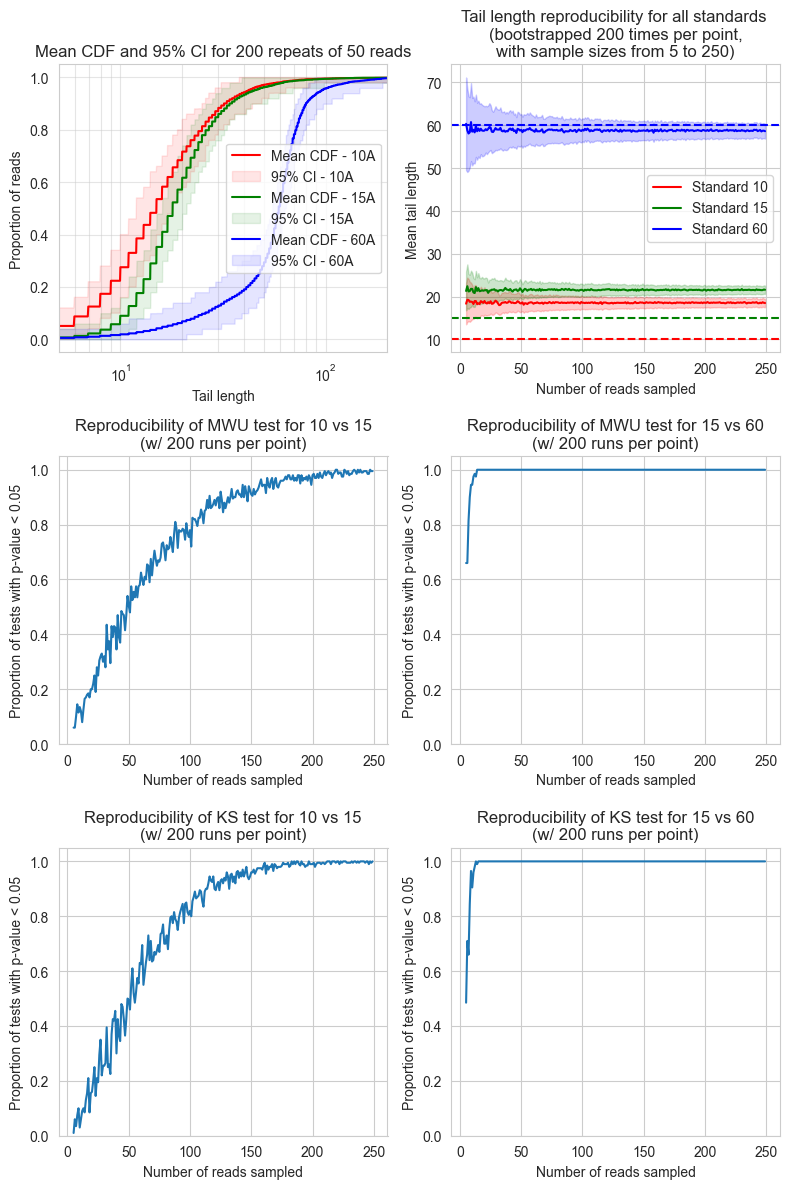

In [8]:
fig = plt.figure(figsize=(8, 12))

# Define colors for each standard
colors = {'10': 'red', '15': 'green', '60': 'blue'}

# Create the top subplot that spans across columns
# ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1)

# Create the bottom left and right subplots
ax2 = plt.subplot2grid((3, 2), (1, 0))
ax3 = plt.subplot2grid((3, 2), (1, 1))

# add two more plots for the KS tests below:
ax4 = plt.subplot2grid((3, 2), (2, 0))
ax5 = plt.subplot2grid((3, 2), (2, 1))

# Now you can use ax1 for the top plot, and ax2 and ax3 for the bottom plots
plot_cdf(standards_df_dict[test_lib], ax__=ax0, log_x=True, sample_size=50, repeats=200)
# sea.ecdfplot(data=standards_df_dict[test_lib], x='polya_length',
#              hue='assignment', ax=ax0, palette=colors)
# ax0.set_title("CDF of tail lengths for different standards")
# ax0.set_xlabel("Tail length")
# ax0.set_ylabel("Proportion of reads")
# ax0.set_xlim(5, 250)
# ax0.set_xscale('log')
# ax0.grid(True, which="both", alpha=0.5)


# Top plot with all the standards
for std in target_standards:
    x = np.array(SUBSET_SIZES)
    y = np.array([subset_means_super_dict[std][size] for size in SUBSET_SIZES])
    sem = np.array([subset_sems_super_dict[std][size] for size in SUBSET_SIZES])
    ax1.plot(x, y, label=f"Standard {std}", color=colors[std])
    ax1.fill_between(x, y-sem, y+sem, alpha=0.2, color=colors[std])
    ax1.axhline(int(std), color=colors[std], linestyle='--')

ax1.set_title("Tail length reproducibility for all standards \n(bootstrapped 200 times per point,\nwith sample sizes from 5 to 250)")
ax1.set_xlabel("Number of reads sampled")
ax1.set_ylabel("Mean tail length")
ax1.legend()

# Middle left plot with 10 vs 15 MWU
sea.lineplot(x=SUBSET_SIZES, y=[mwu_results_10v15[size] for size in SUBSET_SIZES], ax=ax2)
ax2.set_title(f"Reproducibility of MWU test for 10 vs 15\n(w/ {RUNS_PER_SUBSET} runs per point)")
ax2.set_xlabel("Number of reads sampled")
ax2.set_ylabel("Proportion of tests with p-value < 0.05")
ax2.set_ylim(0, 1.05)

# Middle right plot with 15 vs 60 MWU
sea.lineplot(x=SUBSET_SIZES, y=[mwu_results_15v60[size] for size in SUBSET_SIZES], ax=ax3)
ax3.set_title(f"Reproducibility of MWU test for 15 vs 60\n(w/ {RUNS_PER_SUBSET} runs per point)")
ax3.set_xlabel("Number of reads sampled")
ax3.set_ylabel("Proportion of tests with p-value < 0.05")
ax3.set_ylim(0, 1.05)

# Bottom left plot with 10 vs 15 KS
sea.lineplot(x=SUBSET_SIZES, y=[ks_results_10v15[size] for size in SUBSET_SIZES], ax=ax4)
ax4.set_title(f"Reproducibility of KS test for 10 vs 15\n(w/ {RUNS_PER_SUBSET} runs per point)")
ax4.set_xlabel("Number of reads sampled")
ax4.set_ylabel("Proportion of tests with p-value < 0.05")
ax4.set_ylim(0, 1.05)

# Bottom right plot with 15 vs 60 KS
sea.lineplot(x=SUBSET_SIZES, y=[ks_results_15v60[size] for size in SUBSET_SIZES], ax=ax5)
ax5.set_title(f"Reproducibility of KS test for 15 vs 60\n(w/ {RUNS_PER_SUBSET} runs per point)")
ax5.set_xlabel("Number of reads sampled")
ax5.set_ylabel("Proportion of tests with p-value < 0.05")
ax5.set_ylim(0, 1.05)

# Final plot adjustments
plt.tight_layout()
plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{RUNS_PER_SUBSET}perPoint.allInOne.plusKS.plusCDF.png")
plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{RUNS_PER_SUBSET}perPoint.allInOne.plusKS.plusCDF.svg")
plt.show()

## 95% CI for CDFs of tail lengths as another method to show ability to differentiate tails populations with different numbers of observations

### Initial plotting of CDFs for each standard and each subset size:
This just plots 100 different CDFs, but it is a good way to understand what the eventual 95% CI plot is getting its data from!

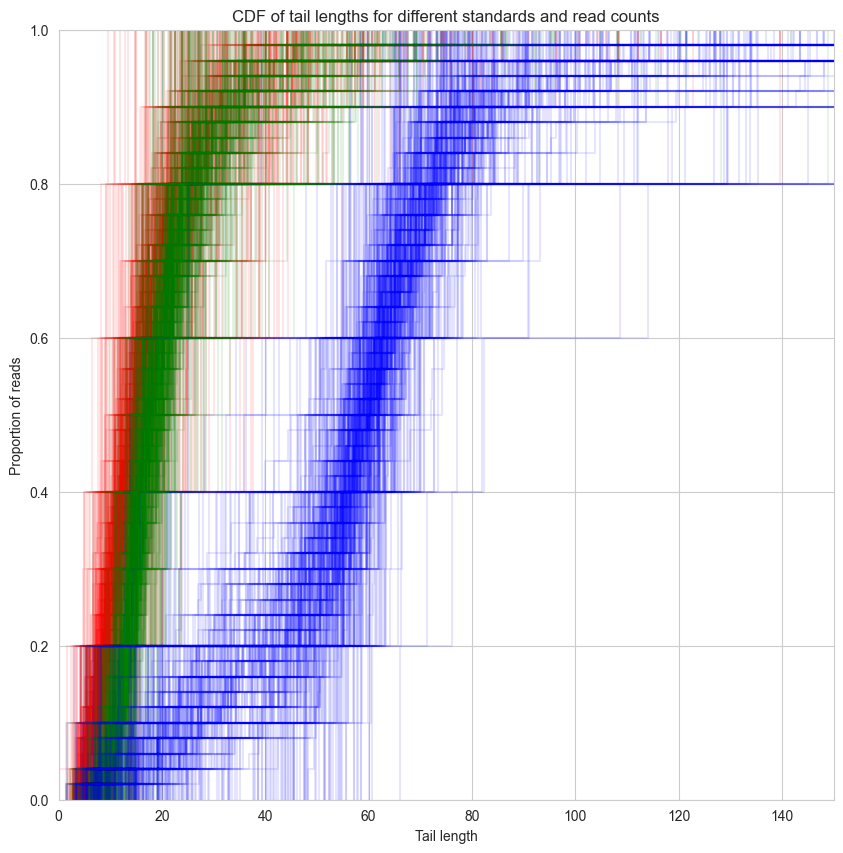

In [9]:
NUM_SUBSETS = 100
fig, ax = plt.subplots(figsize=(10, 10))
for std in target_standards:
    std_df = standards_df_dict[test_lib].query("assignment == @std")
    for size in [5, 10, 25, 50]:
        for i in range(NUM_SUBSETS):
            subset = std_df.sample(size)
            sea.ecdfplot(data=subset, x='polya_length', ax=ax, label=f"{std} - {size} reads", color=colors[std], alpha=0.1)
ax.set_title("CDF of tail lengths for different standards and read counts")
ax.set_xlabel("Tail length")
ax.set_ylabel("Proportion of reads")
# Can we change the limits so we just stop a x = 200:
ax.set_xlim(0, 150)
plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{NUM_SUBSETS}subsets.CDFs.allLines.png")
plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{NUM_SUBSETS}subsets.CDFs.allLines.svg")
plt.show()

### Function to plot the mean CDF and 95% CI for each standard and subset size

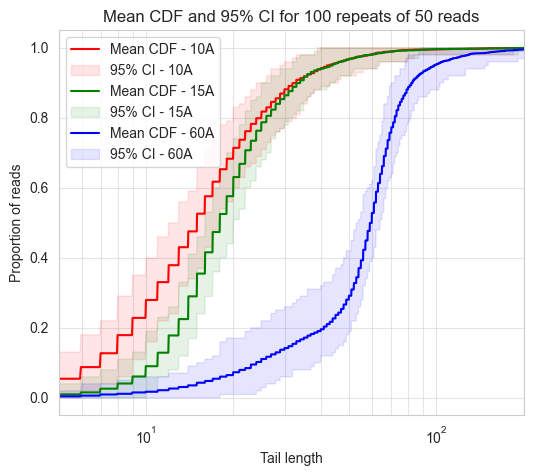

In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def plot_cdf(tester_df__, ax__=None, sample_size=25, repeats=1000,
             stds_color_map={'10': 'red', '15': 'green', '60': 'blue'},
             x_axis_lim=200, log_x=False):
    if ax__ is None:
        fig, ax__ = plt.subplots(figsize=(7, 5))
    
    for std, color in stds_color_map.items():
        std_df = tester_df__.query("assignment == @std")

        x_values = []
        y_values = []

        # Define the bin edges to span the range of 'polya_length_floored' across all subsets
        bin_edges = np.linspace(std_df['polya_length_floored'].min(), std_df['polya_length_floored'].max(), num=10_000)

        for _ in range(repeats):
            try:
                sample_df = std_df.sample(sample_size)
            except ValueError as e:
                if sample_size > std_df.shape[0]:
                    print(f"Sample size too large for std {std}! To resolve this we will sample with replacement!")
                    sample_df = std_df.sample(sample_size, replace=True)
                else:
                    raise e
            except Exception as e:
                print(f"An error occurred with std {std} and sample size {sample_size}!")
                raise e
            # Use the defined bin edges to calculate the histogram
            hist, _ = np.histogram(sample_df['polya_length_floored'], bins=bin_edges)
            # Calculate the cumulative sum to get the CDF
            cdf = np.cumsum(hist)
            # Normalize the CDF by the total count
            cdf = cdf / sample_df.shape[0]
            x_values.append(bin_edges[:-1])  # Exclude the last bin edge because np.histogram returns one more bin edge than the number of bins
            y_values.append(cdf)

        # Convert lists to numpy arrays
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Calculate mean and 95% confidence interval of y values
        mean_y = np.mean(y_values, axis=0)
        lower_bound, upper_bound = np.percentile(y_values, [2.5, 97.5], axis=0)

        # The x values should be the same for all repeats, so just take the x values from the first repeat
        assert (x_values[0] == x_values[1]).all()
        x = x_values[0]
        ax__.plot(x, mean_y, color=color, label=f"Mean CDF - {std}A")
        ax__.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.1, label=f"95% CI - {std}A")
        ax__.set_title(f"Mean CDF and 95% CI for {repeats} repeats of {sample_size} reads")
    ax__.set_xlabel("Tail length")
    ax__.set_ylabel("Proportion of reads")
    ax__.legend()
    
    if log_x:
        ax__.set_xlim(5, x_axis_lim)
        ax__.set_xscale('log')
        ax__.grid(True, which="both", alpha=0.5)
    else:
        ax__.set_xlim(0, x_axis_lim)
        ax__.grid(True, which="both", alpha=0.5)
    
    if ax__ is None:
        plt.show()
    else:
        return ax__

fig, ax = plt.subplots(figsize=(6, 5))
_ = plot_cdf(standards_df_dict[test_lib], ax__=ax, log_x=True, sample_size=50, repeats=100)
plt.show()

### Plotting the 95% CI CDFs for multiple sample sizes

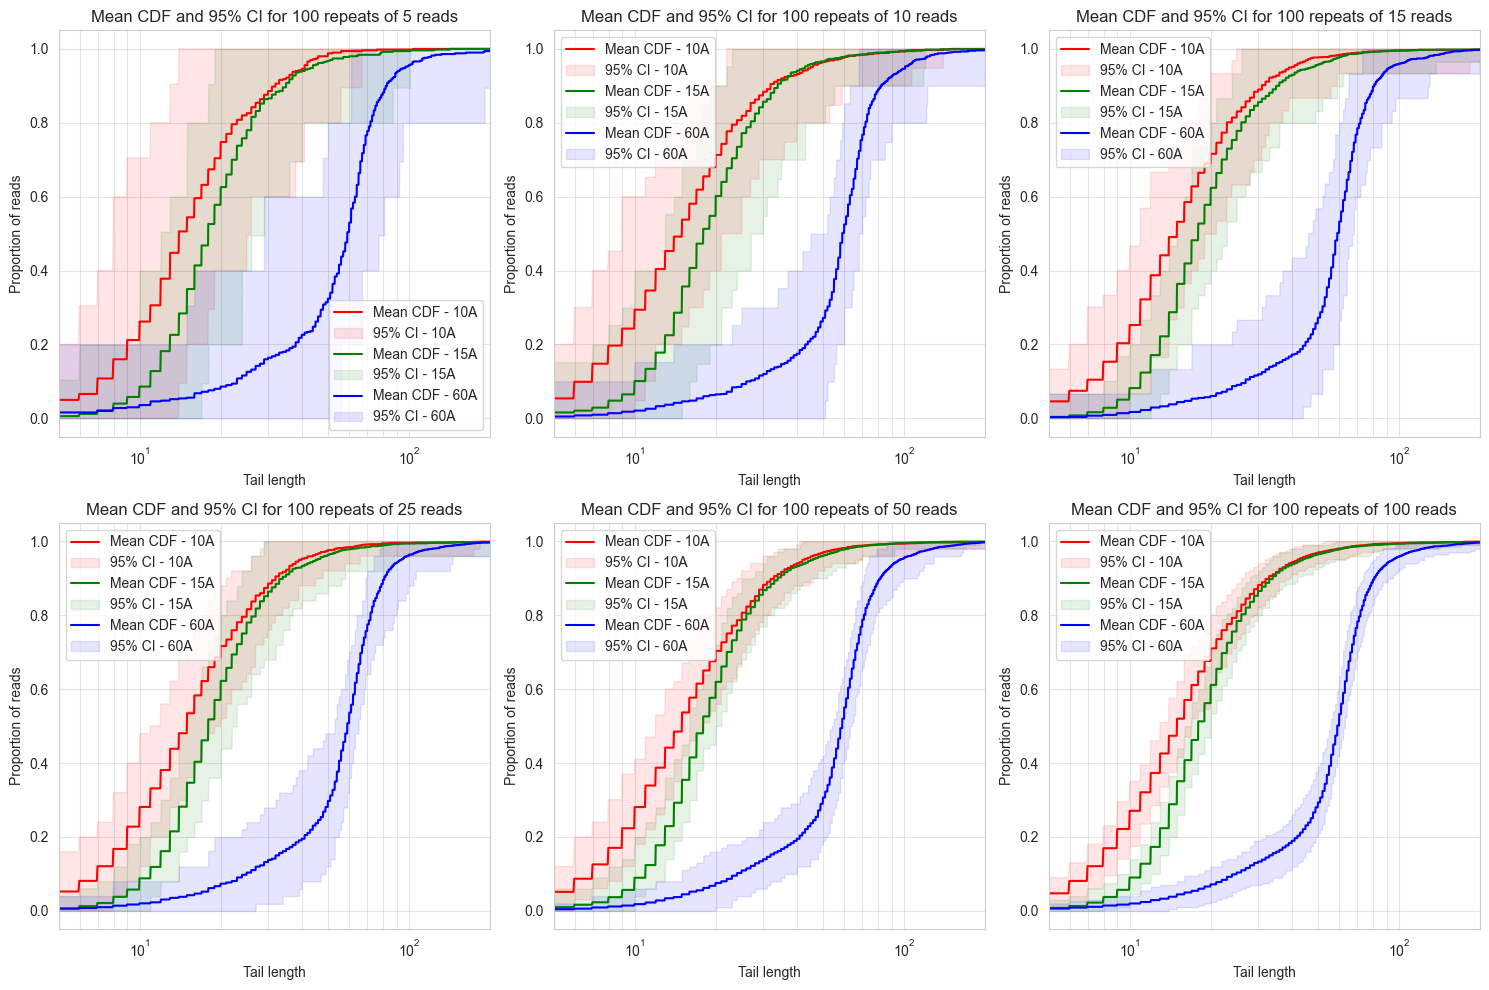

In [11]:
def plot_cdfs(tester_df, sample_sizes, repeats=100, stds_color_map={'10': 'red', '15': 'green', '60': 'blue'}):
    fig, axs = plt.subplots(len(sample_sizes), 1, figsize=(5, 5 * len(sample_sizes)))
    for ax, sample_size in zip(axs, sample_sizes):
        plot_cdf(tester_df, sample_size=sample_size, ax__=ax, repeats=repeats, stds_color_map=stds_color_map)
    plt.tight_layout()
    plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{repeats}repeats.multiSampleSizes.CDFs.95CI.png")
    plt.savefig(f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{repeats}repeats.multiSampleSizes.CDFs.95CI.svg")
    plt.show()

def plot_cdfs_multi_col(tester_df, sample_sizes, repeats=100,
                        stds_color_map={'10': 'red', '15': 'green', '60': 'blue'},
                        col_width=3, col_num=2, row_height=5, log_x=False):
    row_num = (len(sample_sizes) + col_num - 1) // col_num  # Calculate the number of rows
    fig, axs = plt.subplots(row_num, col_num, figsize=(col_width * col_num, row_height * row_num))  # Create a grid of subplots
    axs = axs.flatten()  # Flatten the array of axes
    for ax, sample_size in zip(axs, sample_sizes):
        plot_cdf(tester_df, sample_size=sample_size, ax__=ax, repeats=repeats, stds_color_map=stds_color_map, log_x=log_x)
    plt.tight_layout()
    save_path = f"{fig_out_dir}/tailLengthReproducibility.{test_lib}.{repeats}repeats.multiSampleSizes.CDFs.95CI"
    if log_x:
        save_path += ".log"
    plt.savefig(save_path + ".png")
    plt.savefig(save_path + ".svg")
    plt.show()

# Call the function with a list of sample sizes
plot_cdfs_multi_col(standards_df_dict[test_lib], [5, 10, 15, 25, 50, 100],
                    repeats=100, col_num=3, col_width=5, row_height=5,
                    log_x=True)

# <u>Reproducibility of Abundance</u> (Target II)

## First, data loading:

In [12]:
read_df_dict = {}
gene_df_dict = {}
drop_standards = True

for lib, obj in obj_dict.items():
    print(f"Processing {lib}...")
    read_df = obj.mergedOnReads_df.copy()
    if drop_standards and lib not in  ['oldN2', 'newN2', 'newS5', 'newS6']:
        read_df = read_df.query("assignment == 'NotAStandard'")
    read_df.qc_pass_featc = read_df.qc_pass_featc.fillna(False)
    read_df.qc_pass_featc = read_df.qc_pass_featc.astype(bool)
    cols_to_keep = ['read_id', 'chr_id', 'chr_pos', 'qc_pass_featc', 'gene_id', 'gene_name', 'sequence', 'cigar', 'strand', 'read_length', 'polya_length', 'qc_tag_polya']
    if lib not in  ['oldN2', 'newN2', 'newS5', 'newS6']:
        cols_to_keep += ['assignment']
    read_df_dict[lib] = read_df[cols_to_keep]
    print(read_df.value_counts('qc_pass_featc', normalize=True))
    gene_df = obj.load_compressedOnGenes()  # Looks like the old N2 library had a read cutoff of 5 while everything else had no cutoff!!
    if drop_standards:
        gene_df = gene_df.query("gene_id != 'cerENO2'")
    gene_df_dict[lib] = gene_df

read_hits_series_dict = {}
for lib, df in gene_df_dict.items():
    print(f"Pre-cutdown:  {lib} - {df.shape[0]:,} Genes", end=" ")
    # # TODO: Eventually, I should rerun the compressing for oldN2 without the cutoff!!!
    df = df.query("read_hits >= 2")
    print(f"Post-cutdown: {lib} - {df.shape[0]:,} Genes")
    hits_series = df[['gene_id', 'read_hits']].set_index('gene_id')
    hits_series.rename(columns={'read_hits': lib}, inplace=True)
    read_hits_series_dict[lib] = hits_series

Processing temp25cN2...
qc_pass_featc
True     0.826511
False    0.173489
Name: proportion, dtype: float64
Loading 240701_compressedOnGenes.parquet... Done. Loaded 11,458 rows.
Processing temp25cS5...
qc_pass_featc
True     0.823029
False    0.176971
Name: proportion, dtype: float64
Loading 240701_compressedOnGenes.parquet... Done. Loaded 13,256 rows.
Processing temp25cS6...
qc_pass_featc
True     0.830106
False    0.169894
Name: proportion, dtype: float64
Loading 240701_compressedOnGenes.parquet... Done. Loaded 13,276 rows.
Processing temp25cS7...
qc_pass_featc
True     0.840708
False    0.159292
Name: proportion, dtype: float64
Loading 240701_compressedOnGenes.parquet... Done. Loaded 11,520 rows.
Processing oldN2...
qc_pass_featc
True     0.812672
False    0.187328
Name: proportion, dtype: float64
Loading 240219_compressedOnGenes.parquet... Done. Loaded 12,642 rows.
Processing newerN2...
qc_pass_featc
True     0.824019
False    0.175981
Name: proportion, dtype: float64
Loading 230327

In [13]:
plot_libs = [
    # "oldN2",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
    # Terrible libs to compare them to:
    # "newN2",
    # "newS5",
    # "newS6",
]

plot_read_hits_table = pd.concat({lib: read_hits_series_dict[lib] for lib in plot_libs}.values(), axis=1).fillna(0)
plot_read_hits_table['avg'] = plot_read_hits_table.mean(axis=1)
plot_read_hits_table['avg_rounded'] = plot_read_hits_table['avg'].round(1)
plot_read_hits_table['std'] = plot_read_hits_table.std(axis=1)
plot_read_hits_table['std/avg'] = plot_read_hits_table['std'] / plot_read_hits_table['avg']
if 'gene_name' not in plot_read_hits_table.columns:
    gene_id_gene_name_df = npCommon.gene_names_to_gene_ids()
    plot_read_hits_table.reset_index(names='gene_id', inplace=True)
    plot_read_hits_table = plot_read_hits_table.merge(gene_id_gene_name_df, on='gene_id', how='left')

In [14]:
fig = px.scatter(plot_read_hits_table.query("avg_rounded >= 5"),
                 x='avg_rounded', y='std/avg',
                 hover_name='gene_name',
                 log_x=True,
                 opacity=0.5, )
fig.update_layout(title=f"<b>Reproducibility of gene abundance at various read count cutoffs</b><br>(Libraries: {', '.join(plot_libs)})",
                  xaxis_title="Average reads per gene",
                  yaxis_title="Standard deviation / Average reads per gene",
                  showlegend=False,
                  width=800, height=800)
fig.show()
plot_read_hits_table

gene_id  newerN2  newerS6  newerS5  thirdN2  thirdS5  thirdS6  temp25cN2  temp25cS5  temp25cS6  temp25cS7     avg  avg_rounded          std   std/avg  gene_name  chr
0      WBGene00001168   5037.0   7803.0   3847.0   5592.0   6896.0   2033.0     3481.0     4831.0     4636.0     3815.0  4797.1       4797.1  1519.477030  0.316749   eef-1A.1  III
1      WBGene00004409   3369.0   5371.0   2643.0   3627.0   4149.0   1811.0     2005.0     2778.0     3104.0     2308.0  3116.5       3116.5   972.605147  0.312083      rla-1    I
2      WBGene00004494   3091.0   4966.0   2664.0   3511.0   4206.0   1567.0     2125.0     3146.0     3125.0     2180.0  3058.1       3058.1   914.359632  0.298996     rps-25   IV
3      WBGene00004408   3043.0   5093.0   2370.0   3154.0   3821.0   1664.0     1809.0     2480.0     2591.0     2088.0  2811.3       2811.3   933.900915  0.332195      rla-0    I
4      WBGene00004492   3013.0   4644.0   2281.0   3194.0   3759.0   1555.0     1913.0     2840.0     2706.0     2092.0  2799.7       2799.7   833.310817  0.297643     rps-23   IV
...               ...      ...      ...      ...      ...      ...      ...        ...        ...        ...        ...     ...          ...          ...       ...        ...  ...
14162  WBGene00194914      0.0      0.0      0.0      0.0      0.0      0.0        0.0        0.0        0.0        2.0     0.2          0.2     0.572078  2.860388  F44D12.16   IV
14163  WBGene00003718      0.0      0.0      0.0      0.0      0.0      0.0        0.0        0.0        0.0        2.0     0.2          0.2     0.572078  2.860388    nhr-128    V
14164  WBGene00017498      0.0      0.0      0.0      0.0      0.0      0.0        0.0        0.0        0.0        2.0     0.2          0.2     0.572078  2.860388      pud-4    V
14165  WBGene00003717      0.0      0.0      0.0      0.0      0.0      0.0        0.0        0.0        0.0        2.0     0.2          0.2     0.572078  2.860388    nhr-127    V
14166  WBGene00014949      0.0      0.0      0.0      0.0      0.0      0.0        0.0        0.0        0.0        2.0     0.2          0.2     0.572078  2.860388  Y75B12A.1    V

[14167 rows x 17 columns]

(<Axes: title={'center': 'Reproducibility of gene abundance at various read counts\n(Libraries: oldN2, newerN2, newerS6, newerS5, thirdN2, thirdS5, thirdS6, temp25cN2, temp25cS5, temp25cS6, temp25cS7)'}, xlabel='Average reads per gene', ylabel='Standard deviation / Average reads per gene'>,
                  oldN2  newerN2  newerS6  newerS5  thirdN2  thirdS5  thirdS6  temp25cN2  temp25cS5  temp25cS6  temp25cS7          avg  avg_rounded          std   std/avg
 gene_id                                                                                                                                                                  
 WBGene00012730  8719.0     18.0     91.0     11.0     12.0     22.0      7.0        0.0        5.0       38.0        2.0   811.363636        811.4  2394.271228  2.950923
 WBGene00001168  5236.0   5037.0   7803.0   3847.0   5592.0   6896.0   2033.0     3481.0     4831.0     4636.0     3815.0  4837.000000       4837.0  1459.795534  0.301798
 WBGene00004478  3650.0 

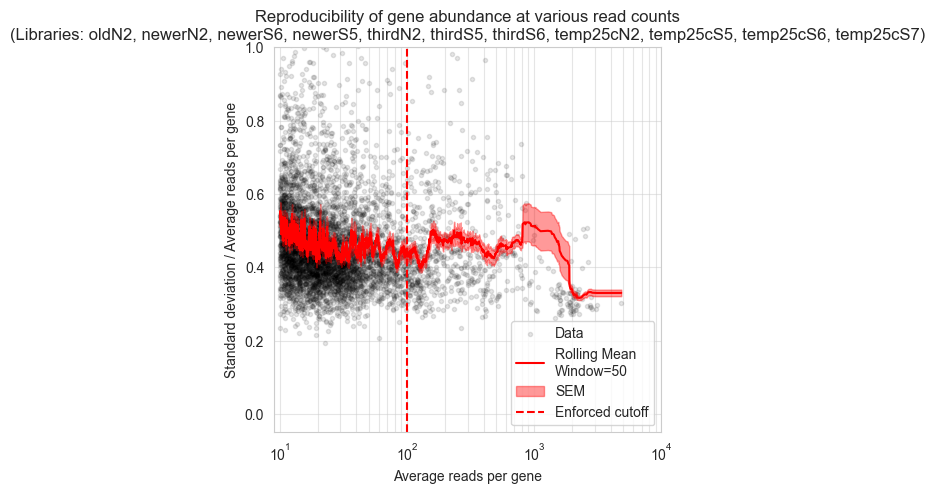

In [15]:
def std_avg_plot(read_hits_series_dict, plot_libs, min_reads=10, filter_average=False, ax=None, gene_id_gene_name_df=None):
    hits_table = pd.concat({lib: read_hits_series_dict[lib] for lib in plot_libs}.values(), axis=1).fillna(0)
    hits_table['avg'] = hits_table.mean(axis=1)
    hits_table['avg_rounded'] = hits_table['avg'].round(1)
    hits_table['std'] = hits_table.std(axis=1)
    hits_table['std/avg'] = hits_table['std'] / hits_table['avg']
    if 'gene_name' not in hits_table.columns and gene_id_gene_name_df is not None:
        hits_table.reset_index(names='gene_id', inplace=True)
        hits_table = hits_table.merge(gene_id_gene_name_df, on='gene_id', how='left')
    min_reads = min_reads
    # Filter and sort the data
    if filter_average:
        data = hits_table.query("avg >= @min_reads").sort_values('avg_rounded')
    else:
        # build query string
        query = " & ".join([f"{lib} >= @min_reads" for lib in plot_libs])
        data = hits_table.query(query).sort_values('avg_rounded')
    # Calculate the rolling mean and standard deviation
    window_size = 50  # Adjust this value as needed
    data['rolling_mean'] = data['std/avg'].rolling(window_size).mean()
    data['rolling_std'] = data['std/avg'].rolling(window_size).std()
    # Calculate the SEM
    data['sem'] = data['rolling_std'] / np.sqrt(window_size)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(data['avg'], data['std/avg'], label='Data', alpha=0.1, color='black',
                # s=5,
                marker='.')
    # Plot the rolling mean and SEM as a shaded region
    ax.plot(data['avg_rounded'], data['rolling_mean'], color='red', label=f'Rolling Mean\nWindow={window_size}')
    ax.fill_between(data['avg_rounded'], data['rolling_mean'] - data['sem'], data['rolling_mean'] + data['sem'],
                     color='red', alpha=0.4, label='SEM')
    # Set the plot title and labels
    ax.set_title(f"Reproducibility of gene abundance at various read counts\n(Libraries: {', '.join(plot_libs)})")
    ax.set_xlabel("Average reads per gene")
    # plt.xlabel("Lowest reads per gene")
    ax.set_ylabel("Standard deviation / Average reads per gene")
    ax.axvline(100, color='red', linestyle='--', label="Enforced cutoff")
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(min_reads-1, 1e4)
    ax.grid(True, which="both", alpha=0.5)
    if ax is None:
        plt.tight_layout()
        plt.savefig(f"{fig_out_dir}/geneAbundanceReproducibility.{'-'.join(plot_libs)}.rollingMean{window_size}.SEM.png")
        plt.savefig(f"{fig_out_dir}/geneAbundanceReproducibility.{'-'.join(plot_libs)}.rollingMean{window_size}.SEM.svg")
        plt.show()
        return None, hits_table
    else:
        return ax, hits_table
    
plot_libs = [
    "oldN2",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
    # Terrible libs to compare them to:
    # "newN2",
    # "newS5",
    # "newS6",
]

std_avg_plot(read_hits_series_dict, plot_libs, min_reads=10, filter_average=True)

In [25]:
name_map = {
    "oldN2": "Wildtype (rep1)",
    "oldS6": "<i>smg-6</i> (rep1)",
    "newerN2": "Wildtype (rep2)",
    "newerS6": "<i>smg-6</i> (rep2)",
    "newerS5": "<i>smg-5</i> (rep2)",
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "<i>smg-5</i> (rep3)",
    "thirdS6": "<i>smg-6</i> (rep3)",
    "temp25cN2": "Wildtype (25°C)",
    "temp25cS5": "<i>smg-5</i> (25°C)",
    "temp25cS6": "<i>smg-6</i> (25°C)",
    "temp25cS7": "<i>smg-7</i> (25°C)",
}
scatter_combos = [
    # ("oldN2", "newerN2"),
    # ("oldN2", "thirdN2"),
    # ("newerN2", "thirdN2"),
    # ("newerS6", "thirdS6"),
    # ("newerS5", "thirdS5"),
    # ("newerN2", "temp25cN2"),
    # ("newerS6", "temp25cS6"),
    # ("newerS5", "temp25cS5"),
    ("thirdN2", "temp25cN2"),
    ("thirdS6", "temp25cS6"),
    ("thirdS5", "temp25cS5"),
    ("temp25cN2", "temp25cS5"),
    ("temp25cN2", "temp25cS6"),
    ("temp25cN2", "temp25cS7"),
    ("temp25cS5", "temp25cS7"),
    ("temp25cS6", "temp25cS7"),
]
# for x_lib, y_lib in scatter_combos:
#     try:
#         data = plot_read_hits_table.query(f"{x_lib} >= @min_reads & {y_lib} >= @min_reads")
#         x = data[x_lib]
#         y = data[y_lib]
#     except Exception as e:
#         print(f"Error: `{e}`, giving up on the plot for: {x_lib} vs {y_lib}!")
#         continue
#     fig = px.scatter(x=x, y=y, hover_name=data['gene_name'],
#                      log_x=True, log_y=True, opacity=0.5)
#     fig.update_traces(marker=dict(size=5,
#                                   color='black'))
#     # I want to add a line at 100 reads per gene on the y and x axes:
#     fig.add_shape(type="line",
#                   x0=100, y0=0, x1=100, y1=1,
#                   line=dict(color="red", width=1, dash="dash"),
#                   xref="x", yref="paper")
#     fig.add_shape(type="line",
#                     x0=0, y0=100, x1=1, y1=100,
#                     line=dict(color="red", width=1, dash="dash"),
#                   xref="paper", yref="y")
#     fig.update_layout(title=f"<b>Reproducibility of gene abundance at various read count cutoffs</b><br>{name_map[x_lib]} vs {name_map[y_lib]}",
#                       xaxis_title=f"Reads per gene - {name_map[x_lib]}",
#                       yaxis_title=f"Reads per gene - {name_map[y_lib]}",
#                       showlegend=False,
#                       width=800, height=800)
#     fig.show()

Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 'newerS6', 'newerS5', 'thirdN2', 'thirdS5', 'thirdS6', 'gene_name', 'chr'], dtype='object')
Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 'newerS6', 'newerS5', 'thirdN2', 'thirdS5', 'thirdS6', 'gene_name', 'chr'], dtype='object')
Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 'newerS6', 'newerS5', 'thirdN2', 'thirdS5', 'thirdS6', 'gene_name', 'chr'], dtype='object')
Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 'newerS6', 'newerS5', 'thirdN2', 'thirdS5', 'thirdS6', 'gene_name', 'chr'], dtype='object')
Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 'newerS6', 'newerS5', 'thirdN2', 'thirdS5', 'thirdS6', 'gene_name', 'chr'], dtype='object')
Index(['gene_id', 'temp25cN2', 'temp25cS5', 'temp25cS6', 'temp25cS7', 'oldN2', 'newerN2', 

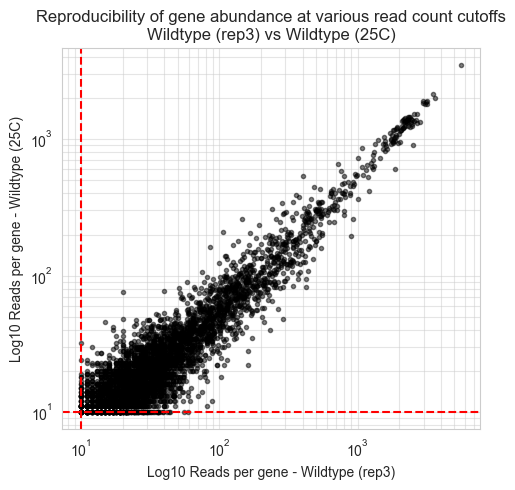

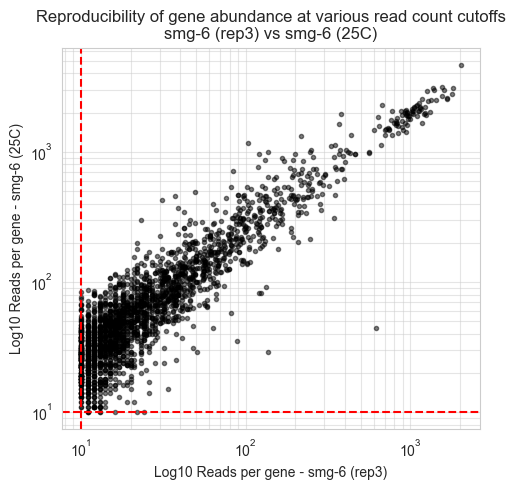

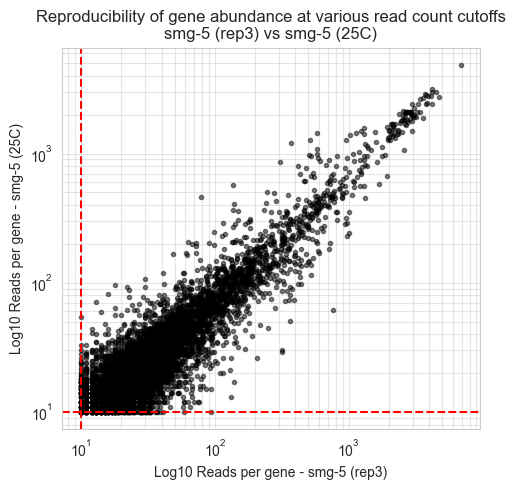

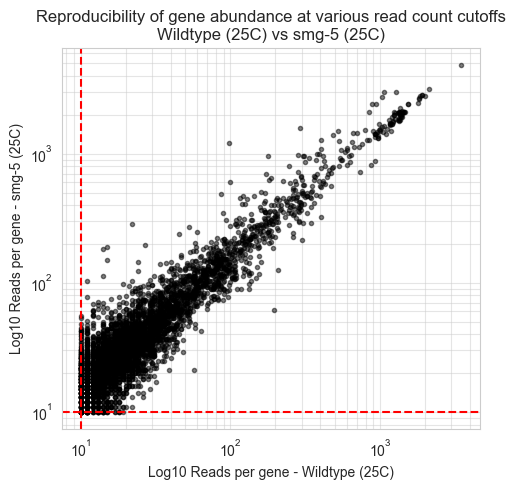

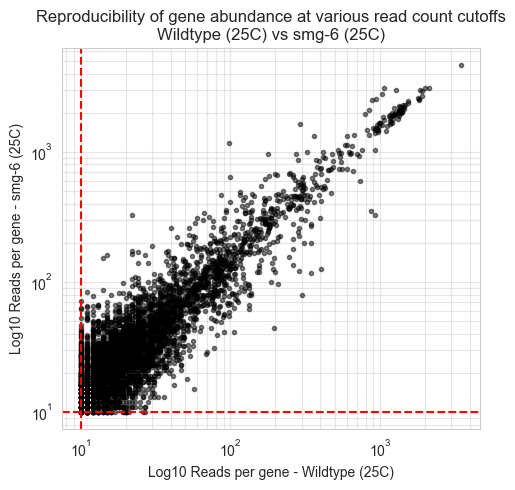

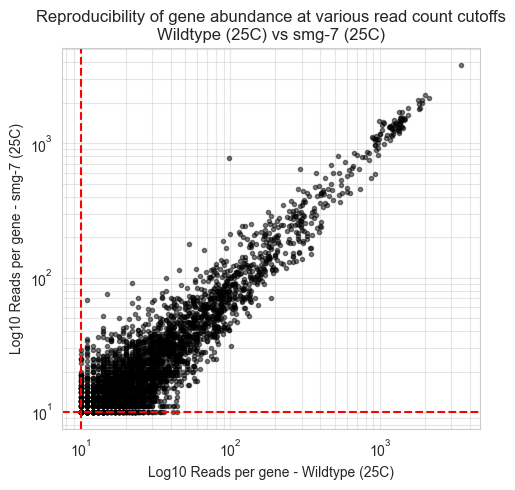

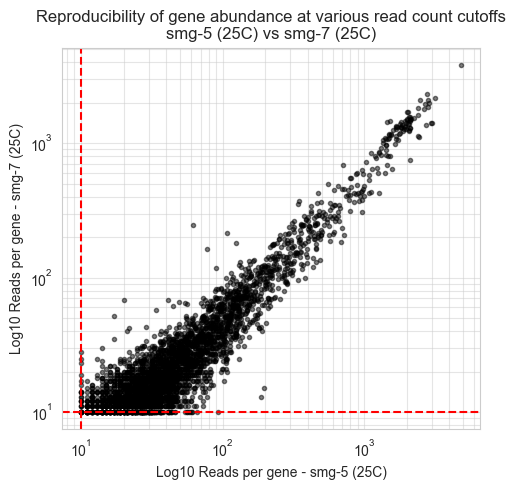

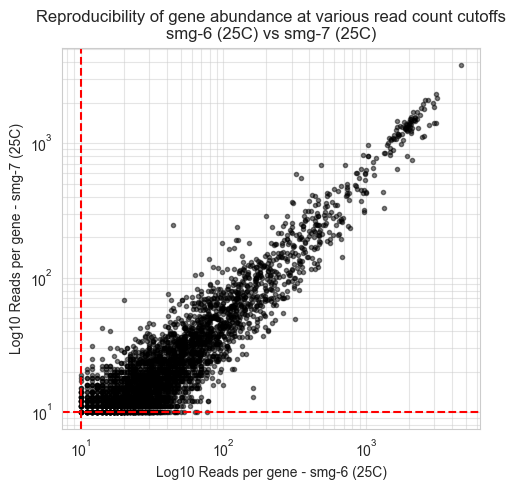

In [30]:
def rocket_plot(x_lib, y_lib, plot_read_hits_table, ax=None, min_reads=10):
    name_map = {
    "oldN2": "Wildtype (rep1)",
    "oldS6": "smg-6 (rep1)",
    "newerN2": "Wildtype (rep2)",
    "newerS6": "smg-6 (rep2)",
    "newerS5": "smg-5 (rep2)",
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "smg-5 (rep3)",
    "thirdS6": "smg-6 (rep3)",
    "temp25cN2": "Wildtype (25C)",
    "temp25cS5": "smg-5 (25C)",
    "temp25cS6": "smg-6 (25C)",
    "temp25cS7": "smg-7 (25C)",
    }
    data = plot_read_hits_table.query(f"{x_lib} >= @min_reads & {y_lib} >= @min_reads")
    try:
        print(plot_read_hits_table.columns)
        data = plot_read_hits_table.query(f"{x_lib} >= @min_reads & {y_lib} >= @min_reads")
        x = data[x_lib]
        y = data[y_lib]
    except Exception as e:
        print(f"Error: `{e}`, giving up on the plot for: {x_lib} vs {y_lib}!")
        return
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    ax.scatter(x=x, y=y, alpha=0.5, color='black', marker='.')

    ax.axvline(min_reads, color='red', linestyle='--')
    ax.axhline(min_reads, color='red', linestyle='--')

    ax.set_title(
        f"Reproducibility of gene abundance at various read count cutoffs\n{name_map[x_lib]} vs {name_map[y_lib]}")
    ax.set_xlabel(f"Log10 Reads per gene - {name_map[x_lib]}")
    ax.set_ylabel(f"Log10 Reads per gene - {name_map[y_lib]}")

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.grid(True, which="both", alpha=0.5)

    plt.tight_layout()
    if ax is None:
        plt.show()
    else:
        return ax

def interactive_rocket_plot(x_lib, y_lib, plot_read_hits_table, min_reads=10):
    name_map = {
    "oldN2": "Wildtype (rep1)",
    "oldS6": "smg-6 (rep1)",
    "newerN2": "Wildtype (rep2)",
    "newerS6": "smg-6 (rep2)",
    "newerS5": "smg-5 (rep2)",
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "smg-5 (rep3)",
    "thirdS6": "smg-6 (rep3)",
    "temp25cN2": "Wildtype (25C)",
    "temp25cS5": "smg-5 (25C)",
    "temp25cS6": "smg-6 (25C)",
    "temp25cS7": "smg-7 (25C)",
    }
    try:
        data = plot_read_hits_table.query(f"{x_lib} >= @min_reads & {y_lib} >= @min_reads")
        data = data[[x_lib, y_lib, 'gene_name']].copy()
    except Exception as e:
        print(f"Error: `{e}`, giving up on the plot for: {x_lib} vs {y_lib}!")
        return
    fig = px.scatter(data, x=x_lib, y=y_lib, hover_name='gene_name',
                     log_x=True, log_y=True, opacity=0.5,
                     title=f"Reproducibility of gene abundance at various read count cutoffs\n"
                           f"{name_map[x_lib]} vs {name_map[y_lib]}",
                     labels={x_lib: f"Log10 Reads per gene - {name_map[x_lib]}",
                             y_lib: f"Log10 Reads per gene - {name_map[y_lib]}"},
                     )
    fig.update_traces(marker=dict(size=5,
                                  color='black'))
    # I want to add a dashed red line at the min_reads cutoff on the horizontal and vertical
    fig.add_shape(type="line",
                  x0=min_reads, y0=0, x1=min_reads, y1=1,
                  line=dict(color="red", width=1, dash="dash"),
                  xref="x", yref="paper")
    fig.add_shape(type="line",
                  x0=0, y0=min_reads, x1=1, y1=min_reads,
                  line=dict(color="red", width=1, dash="dash"),
                  xref="paper", yref="y")
    fig.show(renderer="browser")
    return fig


if 'gene_name' not in plot_read_hits_table.columns:
    gene_id_gene_name_df = npCommon.gene_names_to_gene_ids()
    plot_read_hits_table.reset_index(names='gene_id', inplace=True)
    plot_read_hits_table = plot_read_hits_table.merge(gene_id_gene_name_df, on='gene_id', how='left')

for x_lib, y_lib in scatter_combos:
    rocket_plot(x_lib, y_lib, plot_read_hits_table)
    interactive_rocket_plot(x_lib, y_lib, plot_read_hits_table)

Index(['newerN2', 'thirdN2', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


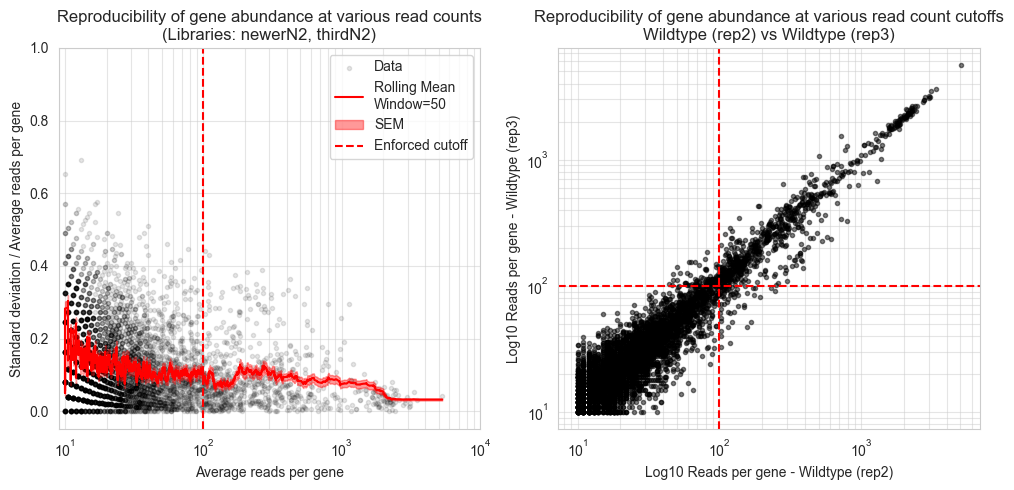

Index(['newerS6', 'thirdS6', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


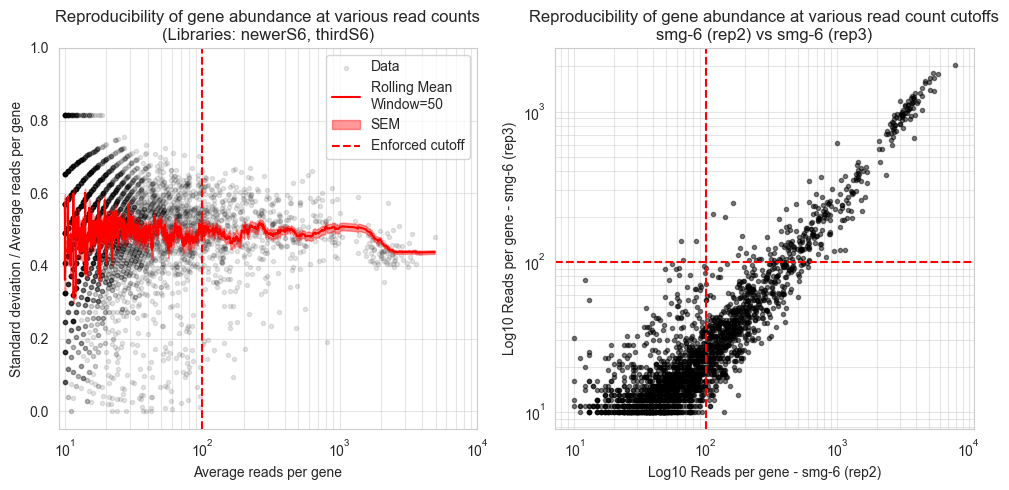

Index(['newerS5', 'thirdS5', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


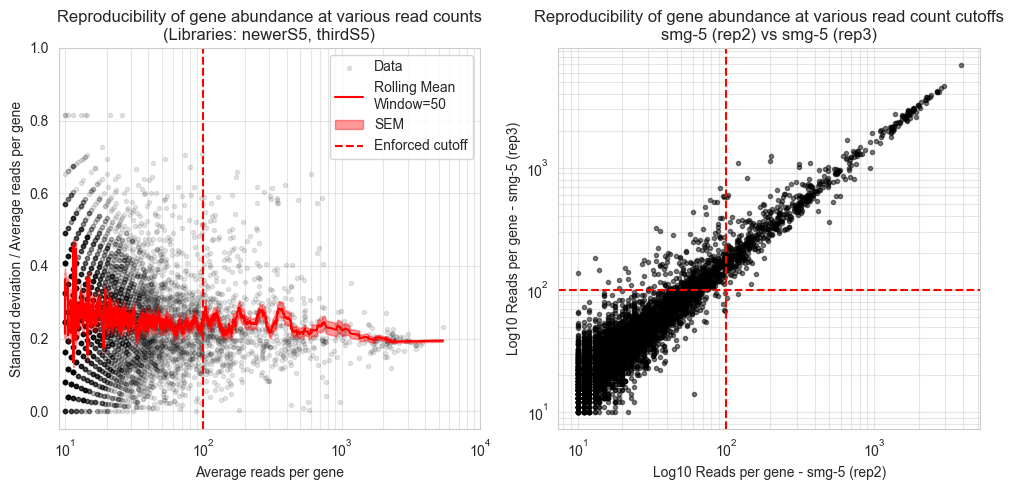

Index(['newerN2', 'temp25cN2', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


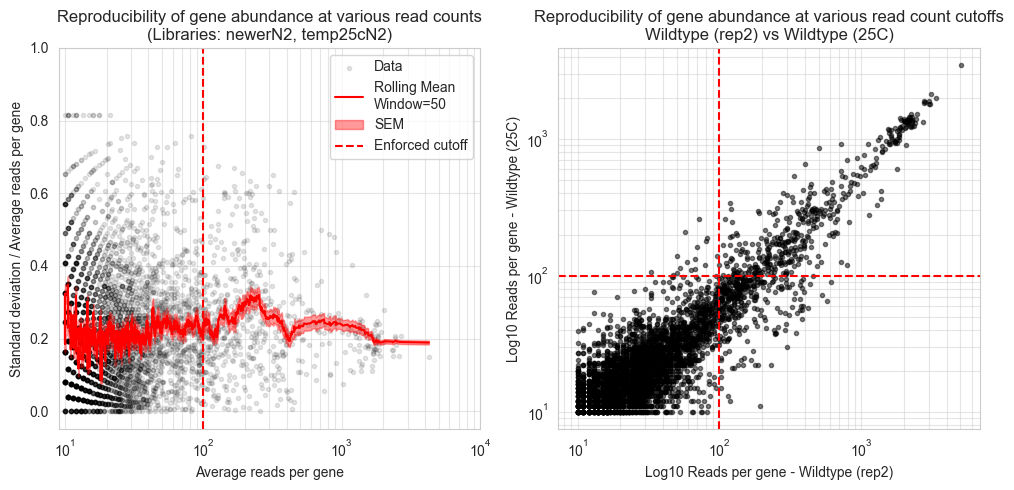

Index(['newerS6', 'temp25cS6', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


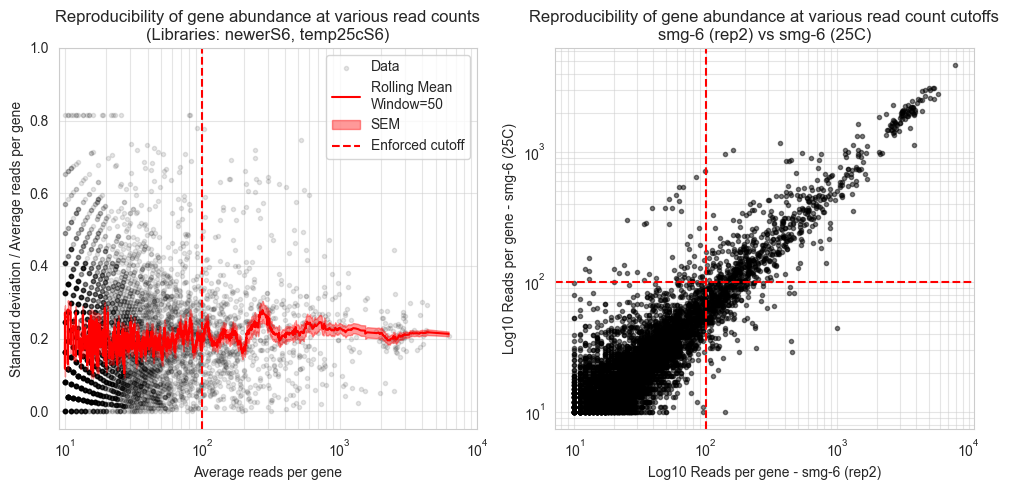

Index(['newerS5', 'temp25cS5', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


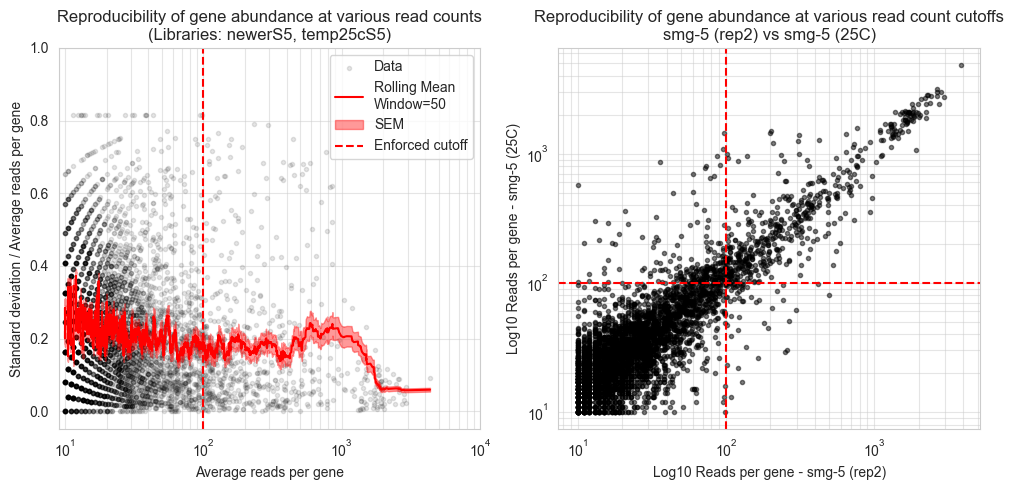

Index(['thirdN2', 'temp25cN2', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


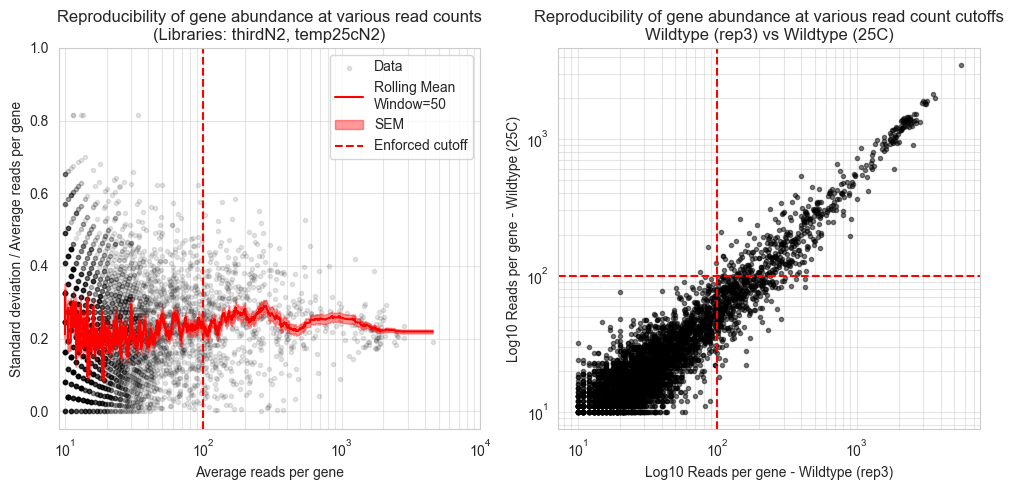

Index(['thirdS6', 'temp25cS6', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


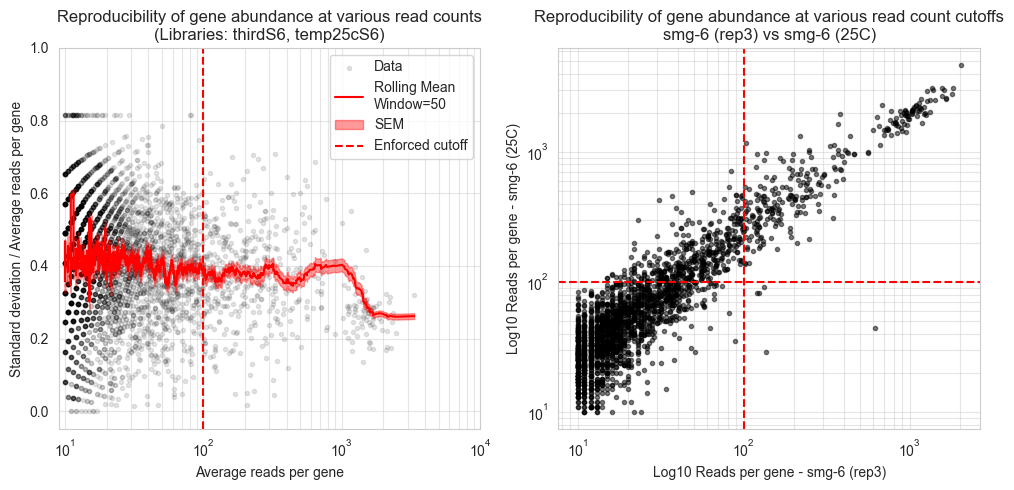

Index(['thirdS5', 'temp25cS5', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


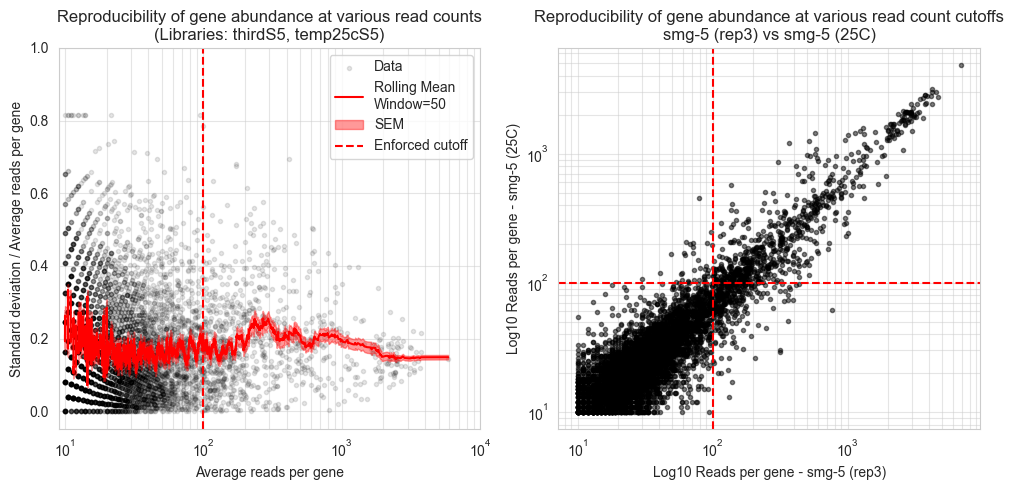

Index(['temp25cN2', 'temp25cS7', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


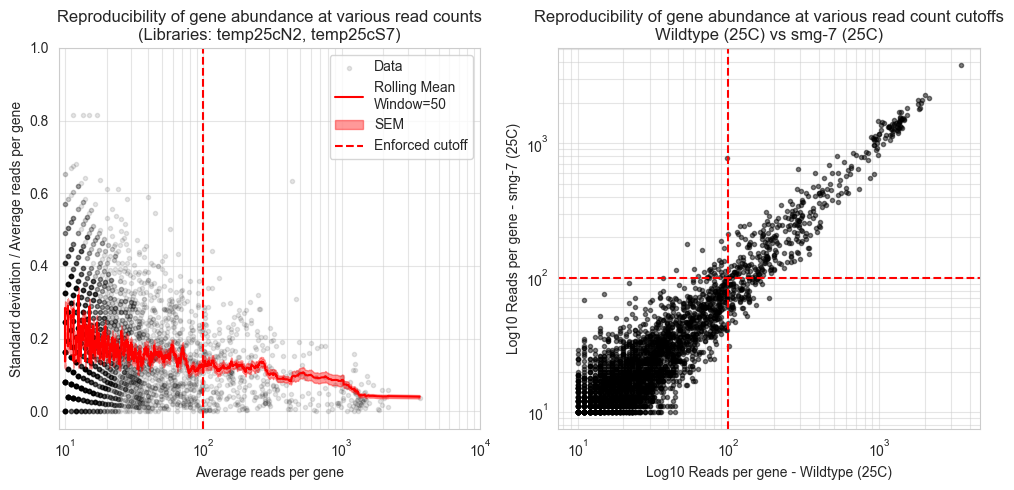

Index(['temp25cS5', 'temp25cS7', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


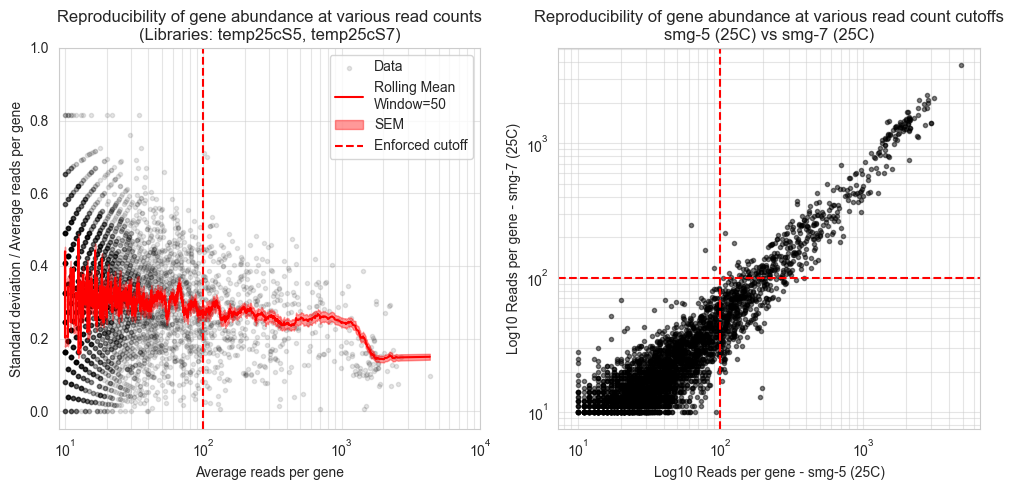

Index(['temp25cS6', 'temp25cS7', 'avg', 'avg_rounded', 'std', 'std/avg'], dtype='object')


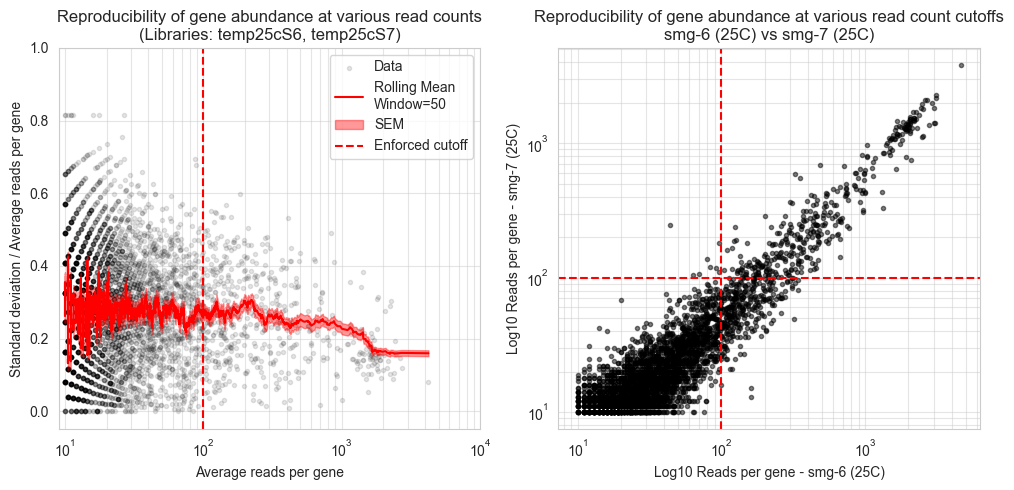

In [18]:
for libs in scatter_combos:
    x_lib, y_lib = libs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1, hits_df = std_avg_plot(read_hits_series_dict, [x_lib, y_lib], min_reads=10, filter_average=True, ax=ax1)
    rocket_plot(x_lib, y_lib, hits_df, ax=ax2)
    plt.tight_layout()
    plt.savefig(f"{fig_out_dir}/geneAbundanceReproducibility.{x_lib}.vs.{y_lib}.combined.png")
    plt.savefig(f"{fig_out_dir}/geneAbundanceReproducibility.{x_lib}.vs.{y_lib}.combined.svg")
    plt.show()

# <u>Saturation analysis</u> (Target III) (Part 2)
Josh thinks we could additionally have a plot with: X-axis = reads_per_gene cutoff (1 to 200?) Y-axis = cumulative number of genes above X cutoff

In [19]:
plot_libs = libs_to_run
plot_read_hits_table = pd.concat({lib: read_hits_series_dict[lib] for lib in plot_libs}.values(), axis=1).fillna(0)
print(plot_read_hits_table.head())

                temp25cN2  temp25cS5  temp25cS6  temp25cS7   oldN2  newerN2  newerS6  newerS5  thirdN2  thirdS5  thirdS6
gene_id                                                                                                                 
WBGene00001168     3481.0     4831.0     4636.0     3815.0  5236.0   5037.0   7803.0   3847.0   5592.0   6896.0   2033.0
WBGene00004494     2125.0     3146.0     3125.0     2180.0  3303.0   3091.0   4966.0   2664.0   3511.0   4206.0   1567.0
WBGene00004409     2005.0     2778.0     3104.0     2308.0  3168.0   3369.0   5371.0   2643.0   3627.0   4149.0   1811.0
WBGene00004492     1913.0     2840.0     2706.0     2092.0  3455.0   3013.0   4644.0   2281.0   3194.0   3759.0   1555.0
WBGene00004477     1903.0     2866.0     2929.0     1981.0  2944.0   2773.0   4450.0   2306.0   2986.0   3733.0   1270.0


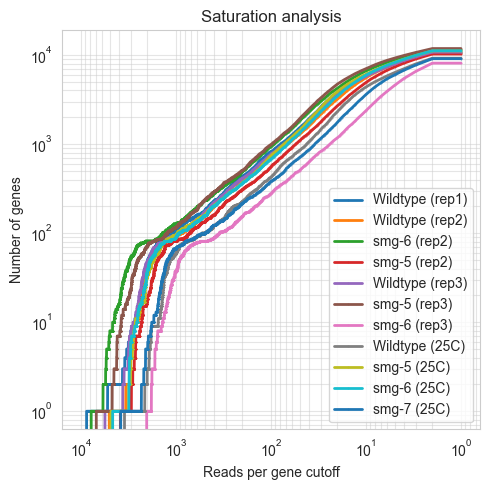

In [20]:
name_map = {
    "oldN2": "Wildtype (rep1)",
    # "oldS6": "smg-6 (rep1)",
    "newerN2": "Wildtype (rep2)",
    "newerS6": "smg-6 (rep2)",
    "newerS5": "smg-5 (rep2)",
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "smg-5 (rep3)",
    "thirdS6": "smg-6 (rep3)",
    "temp25cN2": "Wildtype (25C)",
    "temp25cS5": "smg-5 (25C)",
    "temp25cS6": "smg-6 (25C)",
    "temp25cS7": "smg-7 (25C)",
    # Terrible libs to compare them to:
    # "newN2": "Wildtype (bad rep)",
    # "newS5": "smg-5 (bad rep)",
    # "newS6": "smg-6 (bad rep)",
    }

# Define the range of cutoffs
cutoffs = range(1, 10001)

fig, ax = plt.subplots(figsize=(5, 5))

# Initialize a dict to store the number of genes for each cutoff
num_genes_dict = {}
for lib in name_map.keys():
    num_genes = []
    # For each cutoff, filter the data and count the number of genes
    for cutoff in cutoffs:
        filtered_data = plot_read_hits_table[lib][plot_read_hits_table[lib] >= cutoff]
        num_genes.append(filtered_data.count())
    ax.plot(cutoffs, num_genes, marker='.', label=name_map[lib], linewidth=2, markersize=0.5)
    num_genes_dict[lib] = num_genes

# Plot the number of genes against the cutoff
ax.set_xlabel('Reads per gene cutoff')
ax.set_ylabel('Number of genes')
ax.set_title('Saturation analysis')
ax.grid(True)

# Invert the x-axis
ax.invert_xaxis()
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True, which="both", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.savefig(f"{fig_out_dir}/saturationAnalysis.geneCountsCutoffs.{'-'.join(plot_libs)}.png", dpi=300)
plt.savefig(f"{fig_out_dir}/saturationAnalysis.geneCountsCutoffs.{'-'.join(plot_libs)}.svg")
plt.show()